In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Test the Foward part of the Network
> * Now make sure that we can map from an image into an SxSx2x11 Tensor
> * First make sure that the Yolo2 weights are loadable and make sense.

In [30]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from Model.vis_utils import visualize_grid

In [31]:
# l2 = np.array(list((yolo_weights['model_weights']['conv2d_1']['conv2d_1'][u'kernel:0'])))
# grid = visualize_grid(l2.transpose(3, 1, 2, 0))
# print (grid.shape, l2.shape)
# plt.imshow(grid.astype('uint8'))
# plt.axis('off')
# plt.gcf().set_size_inches(5, 5)
# plt.show()

#### 2.1 Overfit Localizer in Tiny Data
> * For debugging, we run the foward, and backward pass for `a few`
epochs.

In [32]:
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import NutritionDataset
from Model.net import LocalizerNet
from train import train_localizer, calculate_iou

0.4.0


In [39]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/RawImages/'
    BOXES = '../Data/FullData/BoundingBoxes.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    YOLO_PATH = '../Data/FullData/yolo.h5'
    debug = not torch.cuda.is_available()
    dataset = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, debug=debug),
        batch_size=48, shuffle=True, num_workers=16,
    )
    dev = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, split='dev', debug=debug),
        batch_size=48, shuffle=True, num_workers=16,
    )
    model = LocalizerNet(YOLO_PATH)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    r = train_localizer(
        model, optimizer, dataset, dev, epochs=100, 
        scheduler=scheduler, restore=False
    )
    return r    

In [40]:
train_losses, dev_losses, train_map, dev_map = train_localizer_network()

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.882145881652832
	 Dev Loss =  0.9820764064788818
	 Train mAP =  [0. 0. 0. 0.]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.28850704431533813
	 Dev Loss =  0.5870040059089661
	 Train mAP =  [0.25 0.25 0.   0.  ]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.12269732356071472
	 Dev Loss =  0.5149136781692505
	 Train mAP =  [0.35 0.25 0.   0.  ]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.06068873405456543
	 Dev Loss =  0.5117073655128479
	 Train mAP =  [0.6 0.3 0.1 0. ]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0360758975148201
	 Dev Loss =  0.5204163789749146
	 Train mAP =  [0.8 0.8 0.3 0.1]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.02384331077337265
	 Dev Loss =  0.5322785973548889
	 Train mAP =  [1.  0.7 0.7 0.3]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.017322858795523643
	 Dev Loss =  0.5430073738098145
	 Train mAP =  [0.9 0.8 0.8 0.4]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.014904983341693878
	 Dev Loss =  0.5430839657783508
	 Train mAP =  [1.  0.9 0.9 0.6]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.01356081198900938
	 Dev Loss =  0.5438167452812195
	 Train mAP =  [0.9 0.9 0.9 0.8]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.013188831508159637
	 Dev Loss =  0.5449775457382202
	 Train mAP =  [1.  1.  0.9 0.8]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.013067560270428658
	 Dev Loss =  0.5450377464294434
	 Train mAP =  [1.  1.  1.  0.8]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.012982940301299095
	 Dev Loss =  0.5450539588928223
	 Train mAP =  [1.  1.  1.  0.8]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.01289749052375555
	 Dev Loss =  0.545060932636261
	 Train mAP =  [1.  1.  1.  0.9]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.012875965796411037
	 Dev Loss =  0.5450618863105774
	 Train mAP =  [1. 1. 1. 1.]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.012868426740169525
	 Dev Loss =  0.5450624823570251
	 Train mAP =  [1. 1. 1. 1.]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.012860938906669617
	 Dev Loss =  0.5450637340545654
	 Train mAP =  [1. 1. 1. 1.]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.012858849950134754
	 Dev Loss =  0.5450637340545654
	 Train mAP =  [1. 1. 1. 1.]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.012858103960752487
	 Dev Loss =  0.5450634360313416
	 Train mAP =  [1. 1. 1. 1.]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.012857326306402683
	 Dev Loss =  0.5450639724731445
	 Train mAP =  [1. 1. 1. 1.]
	 Dev mAP =  [0. 0. 0. 0.]


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.012856553308665752
	 Dev Loss =  0.5450637340545654
	 Train mAP =  [1. 1. 1. 1.]
	 Dev mAP =  [0. 0. 0. 0.]


In [41]:
def plot(train, dev, title):
    plt.title(title)
    plt.plot(train, label='train'); plt.plot(dev, label='dev')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()

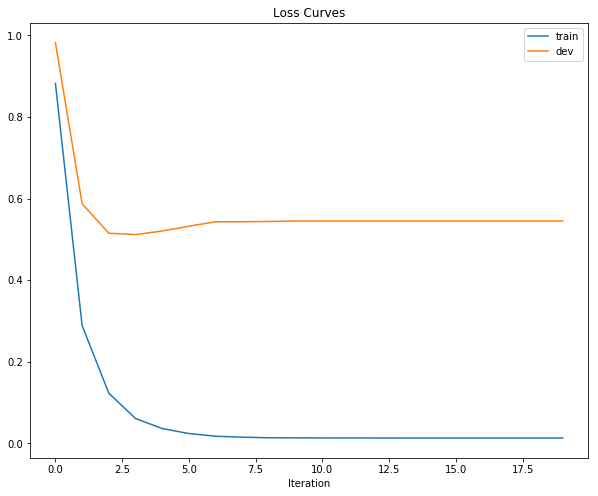

In [42]:
plot(train_losses, dev_losses, title='Loss Curves')

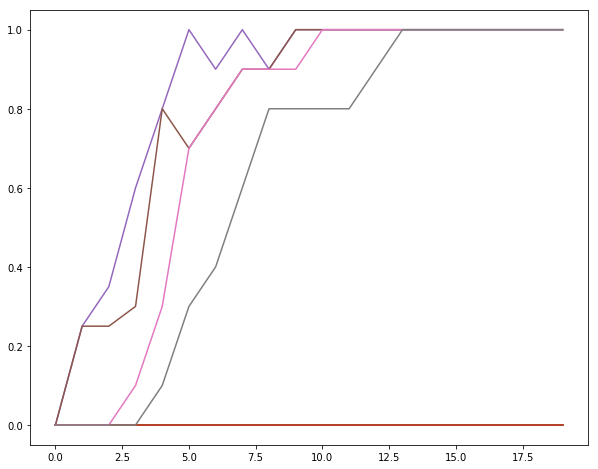

In [43]:
plt.plot(dev_map)
plt.plot(train_map)

In [ ]:
def calculate_mean_image():
    '''
    calculate the mean image on the training set at 
    different sizes, (270, 480) and (540, 960)
    '''
    IMAGE_DIR = '../Data/FullData/RawImages/'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    image_paths = [os.path.join(IMAGE_DIR, f) for f in np.load(DATA_PATH).item()['train']]
    mean_270, mean_540 = np.zeros((480, 270, 3)), np.zeros((960, 540, 3))
    for img in tqdm(image_paths):
        mean_270 += resized_image((1080//4, 1920//4), img)
        mean_540 += resized_image((1080//2, 1920//2), img)
    N = len(image_paths)
    return mean_270 / N, mean_540 / N

def resized_image(size, path):
    with Image.open(path) as img:
        img = img.resize(size, resample=Image.BILINEAR)
        img = np.asarray(img)
    return img

In [ ]:
# # s, l = calculate_mean_image()
# mean_image_s, mean_image_l = (
#     Image.fromarray(s.astype('uint8'), 'RGB'), 
#     Image.fromarray(l.astype('uint8'), 'RGB')
# )